In [1]:
# Importing Neccessary Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('/content/train_v9rqX0R.csv')
df_test = pd.read_csv('/content/test_AbJTz2l.csv')

df_train2 = df_train.copy()
df_test2 = df_test.copy()

df_train2.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
checking_missing_values = pd.DataFrame({'Train': df_train.isnull().mean() * 100, 'Test': df_test.isnull().mean() * 100}).round(2).sort_values(by='Train', ascending=False)
checking_missing_values

,Train,Test
Outlet_Size,28.28,28.27
Item_Weight,17.17,17.18
Item_Fat_Content,0.00,0.00
Item_Identifier,0.00,0.00
Item_Outlet_Sales,0.00,NaN
Item_MRP,0.00,0.00
Item_Visibility,0.00,0.00
Item_Type,0.00,0.00
Outlet_Establishment_Year,0.00,0.00
Outlet_Identifier,0.00,0.00


# 2. Feature Engineering - Part 1 - Imputation

In [4]:
# Obtain Year of Establishment
from datetime import datetime

# Assume a column 'Outlet_Establishment_Year'
df_train2['Years_Operating'] = datetime.now().year - df_train2['Outlet_Establishment_Year']
df_test2['Years_Operating'] = datetime.now().year - df_test2['Outlet_Establishment_Year']

# Labeling Item Identifer
df_train2['Item_Category'] = df_train2['Item_Identifier'].str[:2]
df_train2['Item_Category'].replace({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'}, inplace=True)

df_test2['Item_Category'] = df_test2['Item_Identifier'].str[:2]
df_test2['Item_Category'].replace({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'}, inplace=True)

# Maping Duplicate Item_Fat_Content
df_train2['Item_Fat_Content'].replace({'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'}, inplace=True)
df_test2['Item_Fat_Content'].replace({'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'}, inplace=True)


# # Imputation in Item Weight - Nearest
# df_train2['Item_Weight'] = df_train2['Item_Weight'].interpolate(method='nearest', axis=0) # Check for Linear
# df_test2['Item_Weight'] = df_test2['Item_Weight'].interpolate(method='nearest', axis=0)  # Check for Linear

# Imputation in Item_Weight based on Item_Identifier - Part 1
df_train2['Item_Weight'] = df_train2['Item_Weight'].fillna(df_train2.groupby('Item_Identifier')['Item_Weight'].transform('max')).round(2)
df_test2['Item_Weight'] = df_test2['Item_Weight'].fillna(df_test2.groupby('Item_Identifier')['Item_Weight'].transform('max')).round(2)


# Imputation in Item_Weight based on Item_Type - Part 2
df_train2['Item_Weight'] = df_train2['Item_Weight'].fillna(df_train2.groupby('Item_Type')['Item_Weight'].transform('max')).round(2)
df_test2['Item_Weight'] = df_test2['Item_Weight'].fillna(df_test2.groupby('Item_Type')['Item_Weight'].transform('max')).round(2)

# # Imputation in Item Weight
# df_train2['Item_Weight'] = df_train2['Item_Weight'].interpolate(method='nearest', axis=0)
# df_test2['Item_Weight'] = df_test2['Item_Weight'].interpolate(method='nearest', axis=0)

# # Imputation in Item Weight - Optional
# df_train2['Item_Weight'] = df_train2['Item_Weight'].interpolate(method='nearest', axis=0)
# df_test2['Item_Weight'] = df_test2['Item_Weight'].interpolate(method='nearest', axis=0)


# Imputing Binary Data in Outlet_Size for missing values
df_train2['Outlet_Size'] = df_train2['Outlet_Size'].fillna(df_train2.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.mode().iloc[0]))
df_test2['Outlet_Size'] = df_test2['Outlet_Size'].fillna(df_test2.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.mode().iloc[0]))


# Update MRP values where Item_MRP > Item_Outlet_Sales to match Item_Outlet_Sales
df_train2.loc[df_train2['Item_MRP'] > df_train2['Item_Outlet_Sales'], 'Item_MRP'] = df_train2['Item_Outlet_Sales'].round(2)


# Visibility Imputations & Transformation for Skews
from sklearn.preprocessing import PowerTransformer

# # Replace 0 values with NaN
df_train2['Item_Visibility'] = df_train2['Item_Visibility'].replace(0, np.nan)
df_test2['Item_Visibility'] = df_test2['Item_Visibility'].replace(0, np.nan)


df_train2['Item_Visibility'] = df_train2['Item_Visibility'].interpolate(method='linear', axis=0)
df_test2['Item_Visibility'] = df_test2['Item_Visibility'].interpolate(method='linear', axis=0)


pt_yeo = PowerTransformer(method='yeo-johnson')
df_train2['Item_Visibility_Transformed'] = pt_yeo.fit_transform(df_train2['Item_Visibility'].values.reshape(-1, 1)).ravel()
df_test2['Item_Visibility_Transformed'] = pt_yeo.fit_transform(df_test2['Item_Visibility'].values.reshape(-1, 1)).ravel()


<ipython-input-4-fa72ab1ad954>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train2['Item_Category'].replace({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'}, inplace=True)
<ipython-input-4-fa72ab1ad954>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

# Feature Engineering Part 2 - Combination

In [5]:
# 1 Rounding Weight
df_train2['Item_Weight'] = df_train2['Item_Weight'].round(1)
df_test2['Item_Weight'] = df_test2['Item_Weight'].round(1)

# 2 Rounding MRP
df_train2['Item_MRP'] = df_train2['Item_MRP'].round(1)
df_test2['Item_MRP'] = df_test2['Item_MRP'].round(1)

# MRP Visibility
df_train2['MRP_Visibility'] = (df_train2['Item_MRP'] * df_train2['Item_Visibility']).round(2)
df_test2['MRP_Visibility'] = (df_test2['Item_MRP'] * df_test2['Item_Visibility']).round(2)

# Price Per Unit
df_train2['Price_Per_Unit'] = df_train2['Item_MRP'] / df_train2['Item_Weight']
df_test2['Price_Per_Unit'] = df_test2['Item_MRP'] / df_test2['Item_Weight']

# Visibility_Per_Price
df_train2['Visibility_Per_Price'] = df_train2['Item_Visibility'] / df_train2['Item_MRP']
df_test2['Visibility_Per_Price'] = df_test2['Item_Visibility'] / df_test2['Item_MRP']

# Item Content Type - Classfication
df_train2['Fact_Conetent_Type'] = df_train2['Item_Fat_Content']+" "+df_train2['Item_Category']
df_test2['Fact_Conetent_Type'] = df_test2['Item_Fat_Content']+" "+df_test2['Item_Category']

# Mean Of MRP per Product & Outlet
df_train2['Max_MRP_per_Product_Outlet'] = df_train2.groupby(['Item_Identifier'])['Item_MRP'].transform('max')
df_test2['Max_MRP_per_Product_Outlet'] = df_test2.groupby(['Item_Identifier'])['Item_MRP'].transform('max')

# # # # Outlet Identifier & size
# df_train2['Outlet_Identifier_Size'] = df_train2['Outlet_Identifier'] + '_' + df_train2['Outlet_Size']
# df_test2['Outlet_Identifier_Size'] = df_test2['Outlet_Identifier'] + '_' + df_test2['Outlet_Size']

# # Item Item_Type & Fat Content
# df_train2['Item_Type_Fat_Content'] = df_train2['Item_Type'] + '_' + df_train2['Item_Fat_Content']
# df_test2['Item_Type_Fat_Content'] = df_test2['Item_Type'] + '_' + df_test2['Item_Fat_Content']

# # Combine Vsibility, Outletsize & item type
# df_train2['Visibility_OutletSize_ItemType'] = df_train2['Item_Visibility'].astype(str) + '_' + df_train2['Outlet_Size'] + '_' + df_train2['Item_Type']
# df_test2['Visibility_OutletSize_ItemType'] = df_test2['Item_Visibility'].astype(str) + '_' + df_test2['Outlet_Size'] + '_' + df_test2['Item_Type']

# # Combine Outlet_Identifier & Item Identifier
# df_train2['Outlet_Item_Identifier_Size'] = df_train2['Outlet_Identifier'] + '_' + df_train2['Item_Identifier'] + '_' + df_train2['Outlet_Size']
# df_test2['Outlet_Item_Identifier_Size'] = df_test2['Outlet_Identifier'] + '_' + df_test2['Item_Identifier']+ '_' + df_train2['Outlet_Size']

# EDA

# Understading The training data post imputation & combination

In [6]:
df_train2.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Years_Operating,Item_Visibility_Transformed,MRP_Visibility,Price_Per_Unit,Visibility_Per_Price,Max_MRP_per_Product_Outlet
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8.523000e+03,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.880336,0.070340,140.973906,1997.831867,2181.288914,27.168133,-2.626082e-17,9.895269,12.713262,0.000663,142.398827
std,4.646878,0.049493,62.276499,8.371760,1706.499616,8.371760,1.000059e+00,8.725292,8.026554,0.000716,62.263966
min,4.600000,0.003575,31.300000,1985.000000,33.290000,16.000000,-1.956966e+00,0.280000,1.692683,0.000020,33.400000
25%,8.800000,0.032405,93.800000,1987.000000,834.247400,21.000000,-8.134767e-01,3.670000,6.736132,0.000233,95.000000
50%,12.600000,0.058182,143.000000,1999.000000,1794.331000,26.000000,-4.798914e-02,7.110000,10.965217,0.000439,144.300000
75%,16.800000,0.097094,185.650000,2004.000000,3101.296400,38.000000,7.842234e-01,13.680000,16.226667,0.000827,187.000000
max,21.400000,0.328391,266.900000,2009.000000,13086.964800,40.000000,2.430002e+00,82.360000,50.934783,0.009319,266.900000


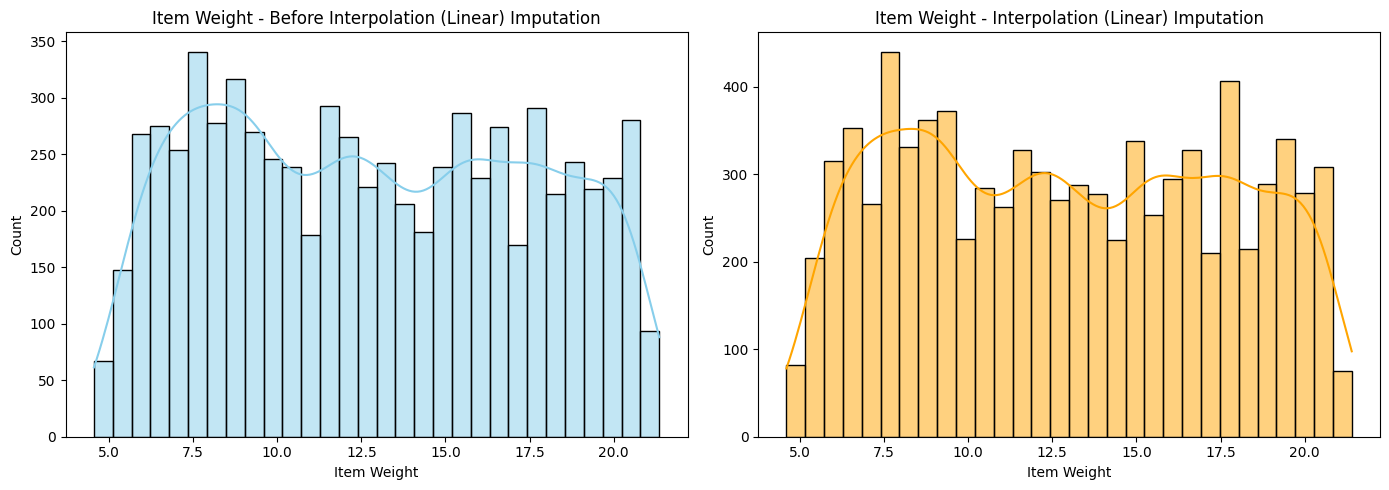

In [7]:
# Weight Distribution Chart Before & After

# Plotting
plt.figure(figsize=(14, 5))

# Histogram - Before
plt.subplot(1, 2, 1)
sns.histplot(df_train['Item_Weight'], bins=30, kde=True, color='skyblue')
plt.title('Item Weight - Before Interpolation (Linear) Imputation')
plt.xlabel('Item Weight')
plt.ylabel('Count')

# Histogram - After
plt.subplot(1, 2, 2)
sns.histplot(df_train2['Item_Weight'], bins=30, kde=True, color='orange')
plt.title('Item Weight - Interpolation (Linear) Imputation')
plt.xlabel('Item Weight')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

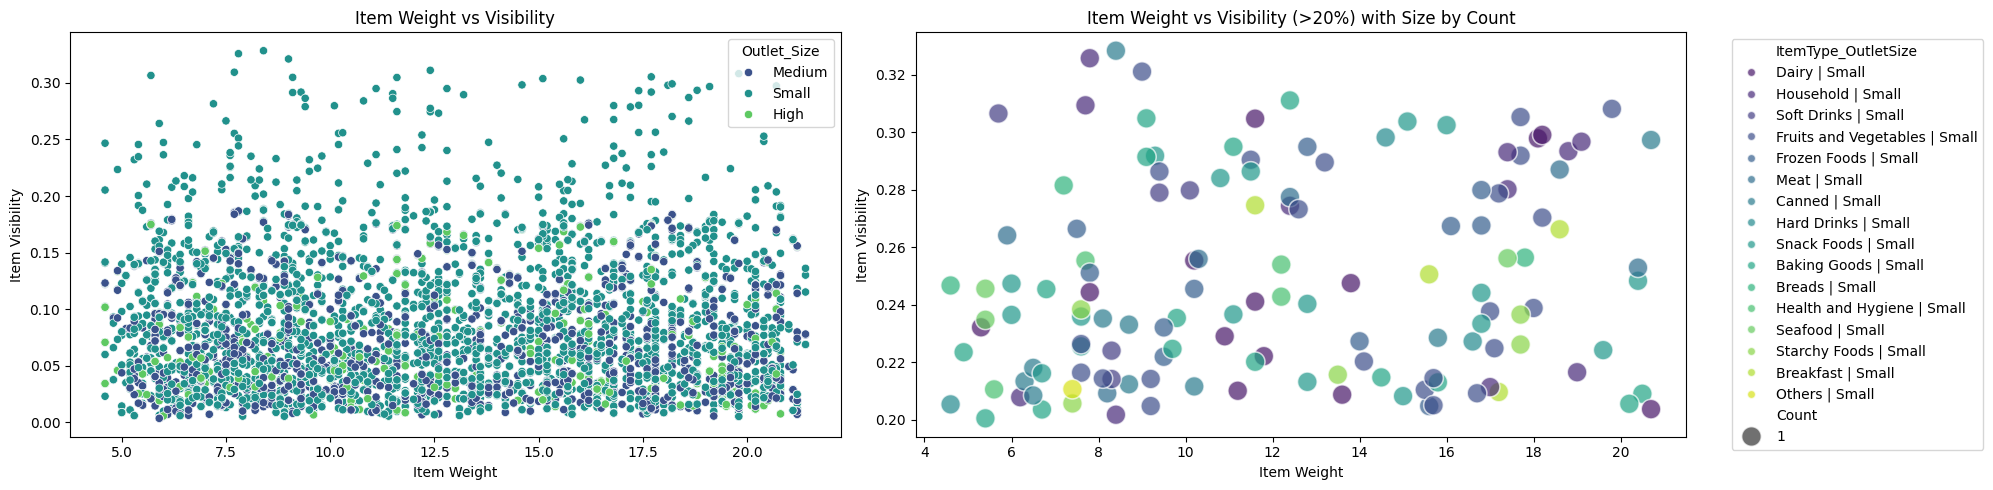

In [8]:
# Item Visibility Overall & Distribution in > 20% Density
# Plotting
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_train2, x='Item_Weight', y='Item_Visibility', hue='Outlet_Size', palette='viridis')
plt.title('Item Weight vs Visibility')
plt.xlabel('Item Weight')
plt.ylabel('Item Visibility')


# Filter visibility > 20%
filtered_df = df_train2[df_train2['Item_Visibility'] > 0.2].copy()

# Create combined hue
filtered_df['ItemType_OutletSize'] = filtered_df['Item_Type'] + ' | ' + filtered_df['Outlet_Size']

# Count duplicate points
count_df = (filtered_df.groupby(['Item_Weight', 'Item_Visibility']).size().reset_index(name='Count'))

# Merge count into filtered_df
filtered_df = pd.merge(filtered_df, count_df, on=['Item_Weight', 'Item_Visibility'], how='left')


plt.subplot(1, 2, 2)
# Scatterplot with size by count
sns.scatterplot(
    data=filtered_df,
    x='Item_Weight',
    y='Item_Visibility',
    hue='ItemType_OutletSize',
    size='Count',
    sizes=(200, 2000),  # control min/max size
    alpha=0.7,
    legend='full',
    palette='viridis'
)

plt.title('Item Weight vs Visibility (>20%) with Size by Count')
plt.xlabel('Item Weight')
plt.ylabel('Item Visibility')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

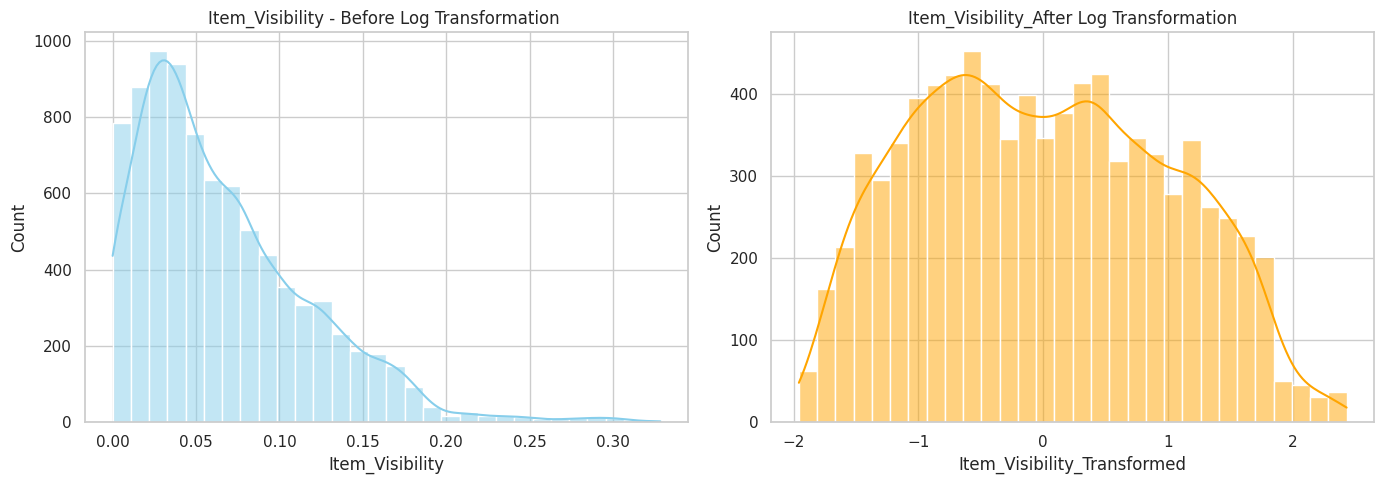

In [25]:
# Visibility Distribution Chart Before & After

# Plotting
plt.figure(figsize=(14, 5))

# Histogram - Before
plt.subplot(1, 2, 1)
sns.histplot(df_train['Item_Visibility'], bins=30, kde=True, color='skyblue')
plt.title('Item_Visibility - Before Log Transformation ')
plt.xlabel('Item_Visibility')
plt.ylabel('Count')

# Histogram - After
plt.subplot(1, 2, 2)
sns.histplot(df_train2['Item_Visibility_Transformed'], bins=30, kde=True, color='orange')
plt.title('Item_Visibility_After Log Transformation')
plt.xlabel('Item_Visibility_Transformed')
plt.ylabel('Count')

plt.tight_layout()
plt.show()



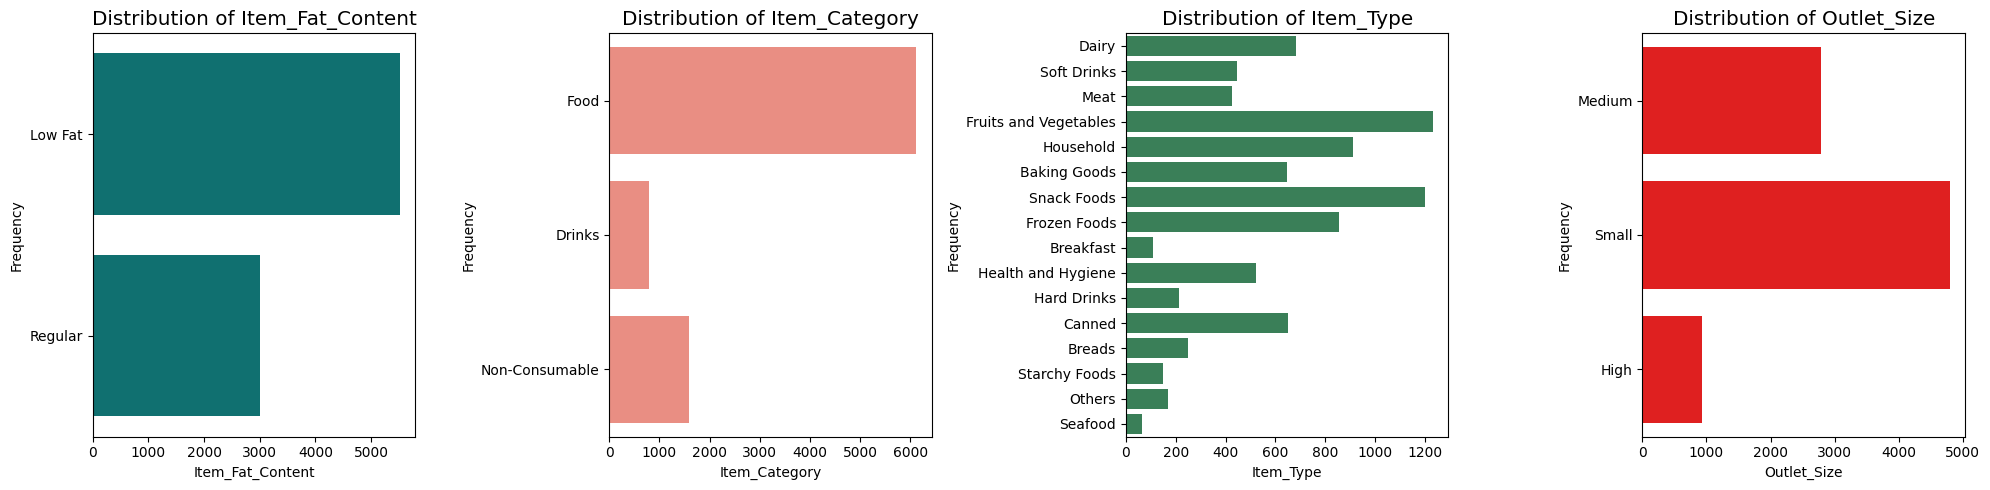

In [10]:
# Distibution of data in Categorical items
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plt.style.use('ggplot')

columns_bin = ['Item_Fat_Content', 'Item_Category','Item_Type', 'Outlet_Size']
colors_bin = ['teal', 'salmon', 'seagreen','red']

# Plot each distribution
for i, col in enumerate(columns_bin):
    sns.countplot(y=df_train2[col], ax=axs[i], color=colors_bin[i])
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')
    axs[i].tick_params(axis='x', labelrotation=0)  # 👈 horizontal labels

plt.tight_layout()
plt.show()


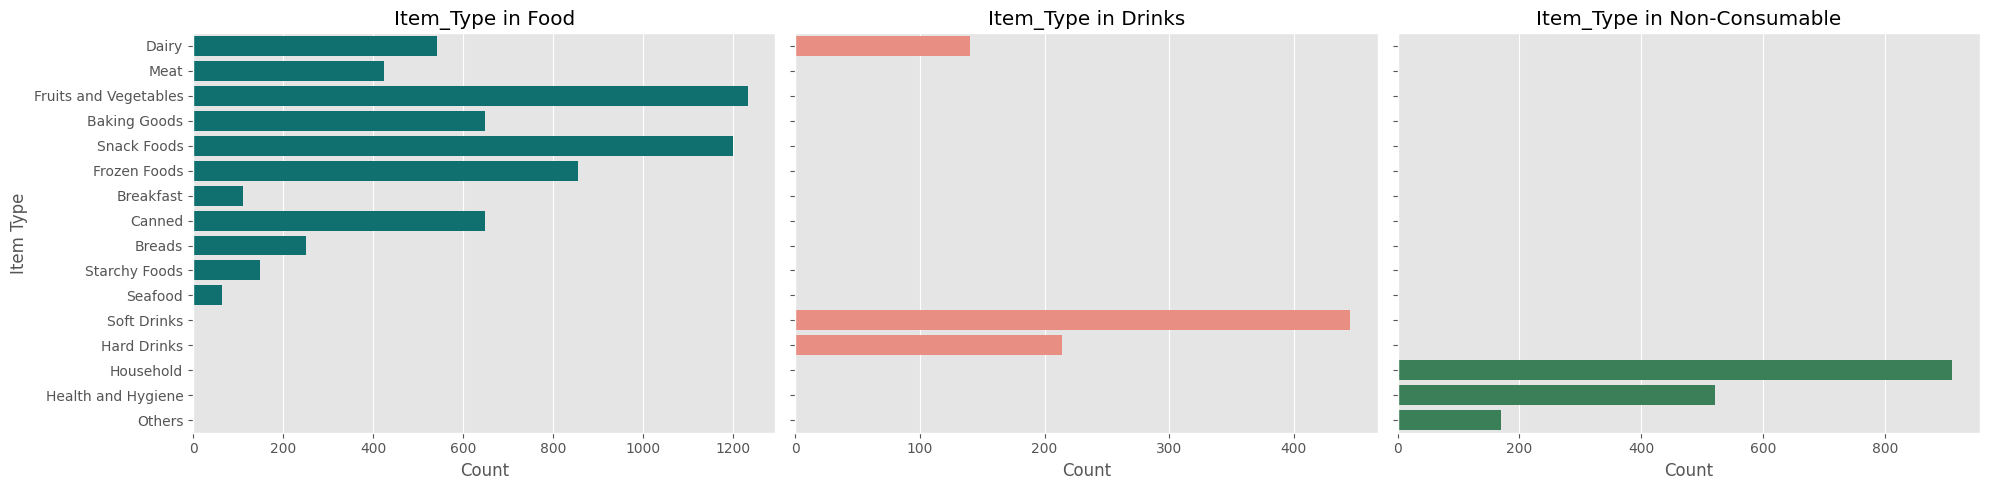

In [11]:
# Chart Showing Item_Category & Sub-Category Distribution
top_categories = df_train2['Item_Category'].unique()[:3]
colors_cate = ['teal', 'salmon', 'seagreen']

# Setup subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
plt.style.use('ggplot')

# Plot each category
for i, cat in enumerate(top_categories):
    sns.countplot(data=df_train2[df_train2['Item_Category'] == cat], y='Item_Type', ax=axs[i], color=colors_cate[i] )
    axs[i].set_title(f'Item_Type in {cat}')
    axs[i].set_xlabel('Count')
    axs[i].set_ylabel('Item Type')

plt.tight_layout()
plt.show()

## Chart Showing Skewness in the data

<ipython-input-12-9de61ae88da3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train2, x='Outlet_Identifier', y='Item_Outlet_Sales', palette='viridis')


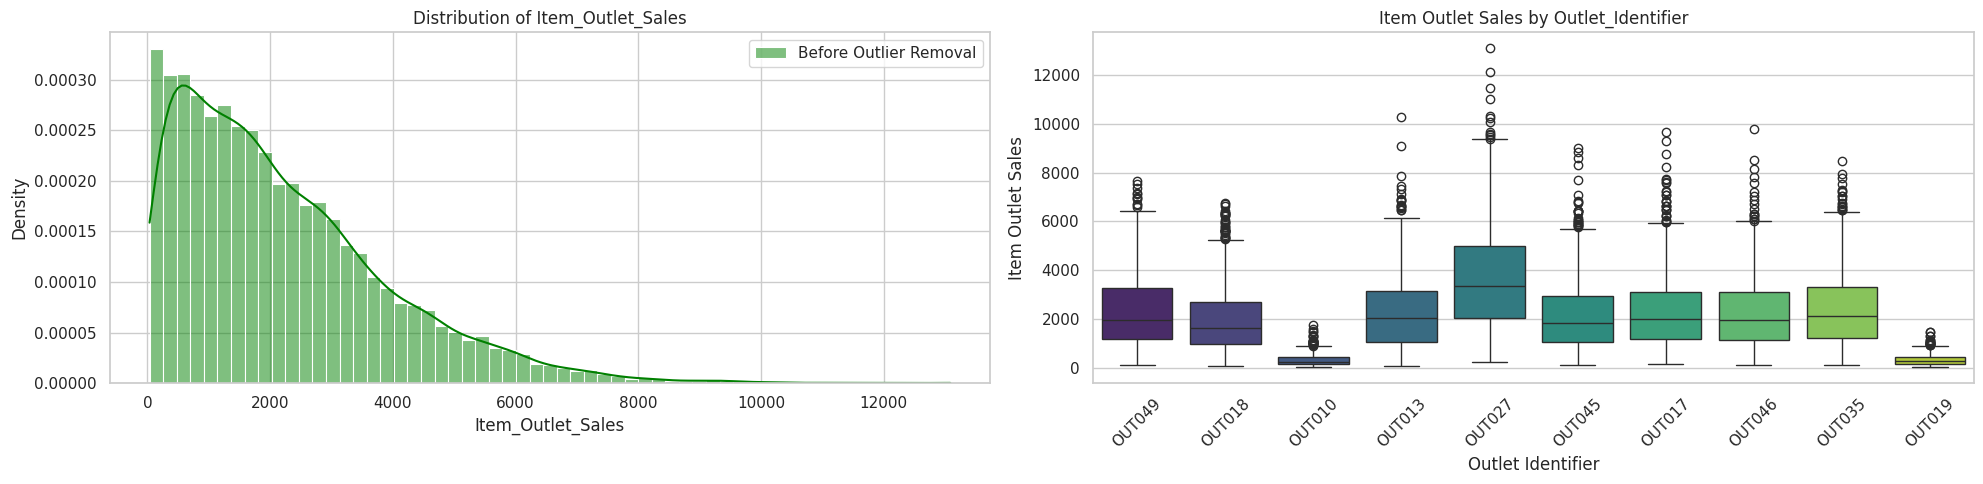

In [12]:

plt.figure(figsize=(20, 5))
sns.set(style="whitegrid")

# Subplot 1: Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_train2['Item_Outlet_Sales'], label='Before Outlier Removal', color='green', kde=True, stat="density", alpha=0.5)
plt.title('Distribution of Item_Outlet_Sales')
plt.xlabel('Item_Outlet_Sales')
plt.ylabel('Density')
plt.legend()

# Subplot 2: Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=df_train2, x='Outlet_Identifier', y='Item_Outlet_Sales', palette='viridis')
plt.title('Item Outlet Sales by Outlet_Identifier')
plt.xlabel('Outlet Identifier')
plt.ylabel('Item Outlet Sales')
plt.xticks(rotation=45)

# Final layout and display
plt.tight_layout()
plt.show()


In [13]:
df_train3 = df_train2.copy()

# Model Building

## Encoding Data for Object DataType

In [14]:
from sklearn.preprocessing import LabelEncoder

encoders = {}

# Ensure df_train2 is a copy to avoid SettingWithCopyWarning
df_train4 = df_train3.copy()

# Apply Label Encoding safely
for col in df_train4.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_train4[col] = le.fit_transform(df_train4[col].astype(str))  # convert to string if needed
    encoders[col] = le

In [15]:
df_train4.describe()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Years_Operating,Item_Category,Item_Visibility_Transformed,MRP_Visibility,Price_Per_Unit,Visibility_Per_Price,Fact_Conetent_Type,Max_MRP_per_Product_Outlet
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8.523000e+03,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,779.714889,12.880336,0.352693,0.070340,7.226681,140.973906,4.722281,1997.831867,1.453596,1.112871,1.201220,2181.288914,27.168133,1.093864,-2.626082e-17,9.895269,12.713262,0.000663,2.151942,142.398827
std,449.222377,4.646878,0.477836,0.049493,4.209990,62.276499,2.837201,8.371760,0.683084,0.812757,0.796459,1706.499616,8.371760,0.522090,1.000059e+00,8.725292,8.026554,0.000716,1.441833,62.263966
min,0.000000,4.600000,0.000000,0.003575,0.000000,31.300000,0.000000,1985.000000,0.000000,0.000000,0.000000,33.290000,16.000000,0.000000,-1.956966e+00,0.280000,1.692683,0.000020,0.000000,33.400000
25%,395.500000,8.800000,0.000000,0.032405,4.000000,93.800000,2.000000,1987.000000,1.000000,0.000000,1.000000,834.247400,21.000000,1.000000,-8.134767e-01,3.670000,6.736132,0.000233,1.000000,95.000000
50%,783.000000,12.600000,0.000000,0.058182,6.000000,143.000000,5.000000,1999.000000,2.000000,1.000000,1.000000,1794.331000,26.000000,1.000000,-4.798914e-02,7.110000,10.965217,0.000439,2.000000,144.300000
75%,1167.000000,16.800000,1.000000,0.097094,10.000000,185.650000,7.000000,2004.000000,2.000000,2.000000,1.000000,3101.296400,38.000000,1.000000,7.842234e-01,13.680000,16.226667,0.000827,4.000000,187.000000
max,1558.000000,21.400000,1.000000,0.328391,15.000000,266.900000,9.000000,2009.000000,2.000000,2.000000,3.000000,13086.964800,40.000000,2.000000,2.430002e+00,82.360000,50.934783,0.009319,4.000000,266.900000


## Split the Data for Train & Test

In [16]:
# X = df_train4.drop(['Item_Outlet_Sales','Outlet_Type','Outlet_Establishment_Year','Outlet_Location_Type','Item_Identifier','Outlet_Size','Item_Visibility'], axis=1)
X = df_train4.drop(['Item_Outlet_Sales'], axis=1) #  'Item_MRP','Item_Visibility'
y = df_train4['Item_Outlet_Sales']
# y = np.log1p(df_train4['Item_Outlet_Sales'])

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Item_Identifier              8523 non-null   int64  
 1   Item_Weight                  8523 non-null   float64
 2   Item_Fat_Content             8523 non-null   int64  
 3   Item_Visibility              8523 non-null   float64
 4   Item_Type                    8523 non-null   int64  
 5   Item_MRP                     8523 non-null   float64
 6   Outlet_Identifier            8523 non-null   int64  
 7   Outlet_Establishment_Year    8523 non-null   int64  
 8   Outlet_Size                  8523 non-null   int64  
 9   Outlet_Location_Type         8523 non-null   int64  
 10  Outlet_Type                  8523 non-null   int64  
 11  Years_Operating              8523 non-null   int64  
 12  Item_Category                8523 non-null   int64  
 13  Item_Visibility_Tr

## Model Building using more efficient method

In [18]:
# Required Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# RFE Feature Selection
n_features = 10  # choose top 10 features (you can adjust)

rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=n_features)
rfe_selector.fit(X_train_scaled, y_train)

# Selected Features
selected_features = X.columns[rfe_selector.support_]
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

# Scale for linear models
X_train_sel_scaled = scaler.fit_transform(X_train_sel)
X_test_sel_scaled = scaler.transform(X_test_sel)

results = []
feature_importance_dict = {}

# Helper to Evaluate Models
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    results.append({
        "Model": name,
        "MAE": round(mae, 4),
        "MSE": round(mse, 4),
        "RMSE": round(rmse, 4),
        "R² Score": round(r2, 4)
    })

# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train_sel_scaled, y_train)
y_pred_lr = lr.predict(X_test_sel_scaled)
evaluate_model("Linear Regression", y_test, y_pred_lr)
# feature_importance_dict["Linear Regression"] = pd.Series(lr.coef_, index=selected_features)

# 2. Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_sel_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_sel_scaled)
evaluate_model("Lasso Regression", y_test, y_pred_lasso)
# feature_importance_dict["Lasso Regression"] = pd.Series(lasso.coef_, index=selected_features)

# 3. Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_sel_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_sel_scaled)
evaluate_model("Ridge Regression", y_test, y_pred_ridge)
# feature_importance_dict["Ridge Regression"] = pd.Series(ridge.coef_, index=selected_features)

# 4. ElasticNet Regression
elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic.fit(X_train_sel_scaled, y_train)
y_pred_elastic = elastic.predict(X_test_sel_scaled)
evaluate_model("ElasticNet Regression", y_test, y_pred_elastic)
# feature_importance_dict["ElasticNet Regression"] = pd.Series(elastic.coef_, index=selected_features)

# 5. Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_sel, y_train)
y_pred_rf = rf.predict(X_test_sel)
evaluate_model("Random Forest", y_test, y_pred_rf)
# feature_importance_dict["Random Forest"] = pd.Series(rf.feature_importances_, index=selected_features)

# 6. XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train_sel, y_train)
y_pred_xgb = xgb.predict(X_test_sel)
evaluate_model("XGBoost", y_test, y_pred_xgb)
feature_importance_dict["XGBoost"] = pd.Series(xgb.feature_importances_, index=selected_features)

# Results Table
results_df = pd.DataFrame(results).sort_values(by="R² Score", ascending=False)
print("Model Evaluation Results:")
print(results_df)

# Display Top Features for Each Model
print("\nTop Features by Model:")
for model, importance in feature_importance_dict.items():
    print(f"\n{model}:")
    print(importance.abs().sort_values(ascending=False).head(5))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.709e+09, tolerance: 2.017e+06
  model = cd_fast.enet_coordinate_descent(


Model Evaluation Results:
                   Model       MAE           MSE       RMSE  R² Score
5                XGBoost  732.9654  1.105709e+06  1051.5268    0.5932
4          Random Forest  758.5982  1.182266e+06  1087.3206    0.5650
1       Lasso Regression  849.6381  1.286807e+06  1134.3753    0.5266
2       Ridge Regression  850.4106  1.288124e+06  1134.9556    0.5261
0      Linear Regression  851.2432  1.289632e+06  1135.6195    0.5255
3  ElasticNet Regression  851.5165  1.296792e+06  1138.7675    0.5229

Top Features by Model:

XGBoost:
Outlet_Type                   0.567667
Item_MRP                      0.205727
Max_MRP_per_Product_Outlet    0.112009
MRP_Visibility                0.024587
Outlet_Location_Type          0.021751
dtype: float32


## Hypertuning XGB Model & Model Evaluation

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Hyperparameter Grid
xgb_param_grid = {
    'xgb__n_estimators': [100, 200 , 1000],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 6, 10],
    'xgb__booster' : ['gbtree'],
    'xgb__tree' : ['auto'],
    'xgb__objective' : ['reg:squarederror'],
    # 'xgb__min_child_weight' :[3],
    # 'xgb__gamma' : [0.5],
    # 'xgb__subsample' : [0.8],
    # 'xgb__colsample_bytree' : [1],
    # 'xgb__reg_alpha' : [0.1],
    # 'xgb__reg_lambda' : [0.1]

}

# Create Pipeline
xgb_pipeline = Pipeline([
    ('xgb', XGBRegressor(random_state=42))
])

# Grid Search
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='r2', n_jobs=-1)
xgb_grid_search.fit(X, y)

# Best XGBoost Model
print("Best XGBoost R² Score:", xgb_grid_search.best_score_)
print("Best XGBoost Parameters:", xgb_grid_search.best_params_)

# Get Top Features Based on Feature Importances
xgb_best_model = xgb_grid_search.best_estimator_
xgb_importance = xgb_best_model.named_steps['xgb'].feature_importances_
xgb_top_features = pd.Series(xgb_importance, index=X.columns).nlargest(5)

# Retrain with Top 5 Features
X_top_xgb = X[xgb_top_features.index]
xgb_best_model.fit(X_top_xgb, y)

# Predict and Evaluate Metrics
y_pred_xgb = xgb_best_model.predict(X_top_xgb)
print("XGBoost MSE:", mean_squared_error(y, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y, y_pred_xgb)))
print("XGBoost R²:", r2_score(y, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:20:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "tree" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost R² Score: 0.5961881033146464
Best XGBoost Parameters: {'xgb__booster': 'gbtree', 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 1000, 'xgb__objective': 'reg:squarederror', 'xgb__tree': 'auto'}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:20:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "tree" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost MSE: 1102652.623420211
XGBoost RMSE: 1050.072675304053
XGBoost R²: 0.6213157138825334


# Applying Prediction to Test Data

In [20]:
from sklearn.preprocessing import LabelEncoder

# Create copy for transformation
df_test3 = df_test2.copy()
encoders_test = {}

# Encode object columns
for col in df_test3.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_test3[col] = le.fit_transform(df_test3[col].astype(str))
    encoders_test[col] = le

In [21]:
# Subset the X_test_data with the top 5 features
X_top_5 = df_test3[xgb_top_features.index]

# Use the trained XGBoost model to make predictions on the new data
y_pred_new = xgb_best_model.predict(X_top_5)

# Output the predictions
print("Predictions for new data:", y_pred_new)

Predictions for new data: [1681.1448  1404.6271   625.81085 ... 1823.854   3624.4783  1234.7583 ]


In [22]:
# Decode in-place (no extra columns)
for col in encoders_test:
    df_test3[col] = encoders_test[col].inverse_transform(df_test3[col])

In [23]:
# Select required columns correctly
sub_xgb = df_test3[['Item_Identifier', 'Outlet_Identifier']].copy()

# Add predicted values
sub_xgb['Item_Outlet_Sales'] = y_pred_new

# Sort by predictions
sub_xgb = sub_xgb.sort_values(by='Item_Outlet_Sales', ascending=True)

# Optional: Reset index
sub_xgb.reset_index(drop=True, inplace=True)

# Save to CSV without including the index in the CSV file
sub_xgb.to_csv('/content/xgb_sumi.csv', index=False)

In [24]:
sub_xgb.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,NCY05,OUT010,25.099850
1,FDX59,OUT010,25.099850
2,FDU21,OUT010,25.099850
3,NCR42,OUT019,40.936684
4,FDT36,OUT019,40.936684
